Импорт необходимых библиотек

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from scipy import stats

Задача 1. Загрузить данные из файла train.csv. Подготовить данные для
дальнейшего анализа, исключив их них экстремально большие
значения.

In [18]:
# Загрузка данных
df = pd.read_csv('train.csv')

# Заполнение пропусков медианным значением
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

# Определение выбросов с использованием метода межквартильного размаха (IQR)
Q1 = df['LotFrontage'].quantile(0.25)  # Первый квартиль (25%)
Q3 = df['LotFrontage'].quantile(0.75)  # Третий квартиль (75%)
IQR = Q3 - Q1  # Межквартильный размах

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Исключаем экстремально большие значения (выбросы)
df_cleaned = df[(df['LotFrontage'] >= lower_bound) & (df['LotFrontage'] <= upper_bound)]

# Проверим размер исходных и очищенных данных
print("Размер исходных данных:", df.shape)
print("Размер очищенных данных:", df_cleaned.shape)

Размер исходных данных: (1460, 81)
Размер очищенных данных: (1354, 81)


Задача 2. Подобрать три непрерывных распределения (минимум два должны
подходить по форме) и с помощью каждого из них приблизить
соответствующие распределения выборочных данных. Вывести оценки параметров распределения. Построить графики.

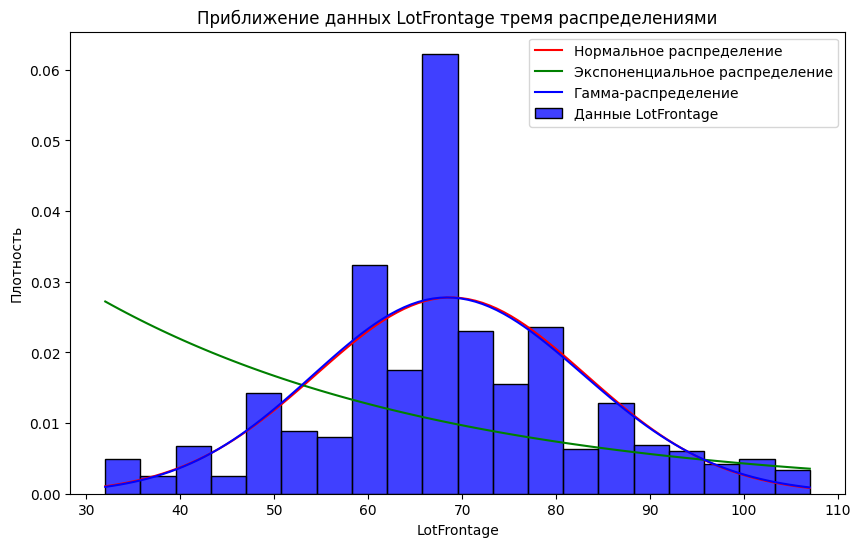

Нормальное распределение: статистика       = 0.11751704050709866, p-value = 9.49535083645941e-17
Экспоненциальное распределение: статистика = 0.34388620081940846, p-value = 1.7233276673800164e-143
Гамма-распределение: статистика            = 0.11404561218978893, p-value = 8.500674472986496e-16


In [19]:
lotfrontage_data = df_cleaned['LotFrontage']

# Подбор трех распределений: нормальное, экспоненциальное, гамма-распределение
# 1. Нормальное распределение
mu_norm, sigma_norm = stats.norm.fit(lotfrontage_data) # подбираем параметры нормального распределения
x = np.linspace(lotfrontage_data.min(), lotfrontage_data.max(), 100)
pdf_norm = stats.norm.pdf(x, mu_norm, sigma_norm)

# 2. Экспоненциальное распределение
loc_exp, scale_exp = stats.expon.fit(lotfrontage_data) # подбираем параметры экспоненциального распределения
pdf_exp = stats.expon.pdf(x, loc_exp, scale_exp)

# 3. Гамма-распределение
shape_gamma, loc_gamma, scale_gamma = stats.gamma.fit(lotfrontage_data) # подбираем параметры гамма-распределения
pdf_gamma = stats.gamma.pdf(x, shape_gamma, loc_gamma, scale_gamma)

# Визуализация результатов: наложение распределений на гистограмму данных
plt.figure(figsize=(10,6))
sb.histplot(lotfrontage_data, bins=20, kde=False, stat="density", color='blue', label='Данные LotFrontage')
plt.plot(x, pdf_norm, 'r-', label='Нормальное распределение')
plt.plot(x, pdf_exp, 'g-', label='Экспоненциальное распределение')
plt.plot(x, pdf_gamma, 'b-', label='Гамма-распределение')
plt.title('Приближение данных LotFrontage тремя распределениями')
plt.xlabel('LotFrontage')
plt.ylabel('Плотность')
plt.legend()
plt.show()

# Статистические тесты для оценки соответствия
stat_norm, p_norm = stats.kstest(lotfrontage_data, 'norm', args=(mu_norm, sigma_norm))
stat_exp, p_exp = stats.kstest(lotfrontage_data, 'expon', args=(loc_exp, scale_exp))
stat_gamma, p_gamma = stats.kstest(lotfrontage_data, 'gamma', args=(shape_gamma, loc_gamma, scale_gamma))

# Вывод результатов
print(f"Нормальное распределение: статистика       = {stat_norm}, p-value = {p_norm}")
print(f"Экспоненциальное распределение: статистика = {stat_exp}, p-value = {p_exp}")
print(f"Гамма-распределение: статистика            = {stat_gamma}, p-value = {p_gamma}")

Задача 3. Для проверки согласованности данных с распределением и выбора
лучшего приближения необходимо провести Хи-квадрат тест. Логику
работы теста реализовать самому.

In [25]:
import numpy as np
from scipy import stats

# Функция для расчёта статистики Хи-квадрат
def chi_square_test(observed_freq, expected_freq):
    # Исключаем бины с нулевыми ожидаемыми частотами
    non_zero_mask = expected_freq > 0
    # Sum_i((наблюдаемая_частота - ожидаемая_частота)^2 / ожидаемая_частота)
    chi2_stat = np.sum((observed_freq[non_zero_mask] - expected_freq[non_zero_mask]) ** 2 / expected_freq[non_zero_mask])
    return chi2_stat

# Задаем количество бинов
num_bins = 10

# Выбираем данные LotFrontage
lot_frontage = df['LotFrontage']

# Строим гистограмму для данных LotFrontage (наблюдаемые частоты)
observed_freq, bin_edges = np.histogram(lot_frontage, bins=num_bins)

# Ожидаемые частоты для нормального распределения
params_norm = stats.norm.fit(lot_frontage)
expected_freq_norm = stats.norm.pdf(bin_edges[:-1], *params_norm) * np.diff(bin_edges) * len(lot_frontage)

# Ожидаемые частоты для гамма распределения
params_gamma = stats.gamma.fit(lot_frontage)
expected_freq_gamma = stats.gamma.pdf(bin_edges[:-1], *params_gamma) * np.diff(bin_edges) * len(lot_frontage)

# Ожидаемые частоты для экспоненциального распределения
params_expon = stats.expon.fit(lot_frontage)
expected_freq_expon = stats.expon.pdf(bin_edges[:-1], *params_expon) * np.diff(bin_edges) * len(lot_frontage)

# Вычисляем статистику Хи-квадрат для каждого распределения
chi2_norm = chi_square_test(observed_freq, expected_freq_norm)
chi2_gamma = chi_square_test(observed_freq, expected_freq_gamma)
chi2_expon = chi_square_test(observed_freq, expected_freq_expon)

# Степени свободы = число бинов - число оценённых параметров
dof = num_bins - 2  # для нормального распределения с двумя параметрами

# Критическое значение для теста Хи-квадрат (на уровне значимости 0.05)
critical_value = stats.chi2.ppf(0.95, dof)

# Сравниваем статистики с критическим значением
print(f'Хи-квадрат для нормального распределения: {chi2_norm:.2f}')
print(f'Хи-квадрат для гамма распределения: {chi2_gamma:.2f}')
print(f'Хи-квадрат для экспоненциального распределения: {chi2_expon:.2f}')
print(f'Критическое значение Хи-квадрат: {critical_value:.2f}')

Хи-квадрат для нормального распределения: 1625213704205440256.00
Хи-квадрат для гамма распределения: 64738081.01
Хи-квадрат для экспоненциального распределения: 1107.44
Критическое значение Хи-квадрат: 15.51


Задача 4. Сделать вывод о качестве аппроксимации.

In [24]:
# Проверяем гипотезу: если chi2_stat < critical_value, мы не отвергаем нулевую гипотезу
if chi2_norm < critical_value:
    print('Нормальное распределение хорошо согласуется с данными')
else:
    print('Нормальное распределение не согласуется с данными')

if chi2_gamma < critical_value:
    print('Гамма распределение хорошо согласуется с данными')
else:
    print('Гамма распределение не согласуется с данными')

if chi2_expon < critical_value:
    print('Экспоненциальное распределение хорошо согласуется с данными')
else:
    print('Экспоненциальное распределение не согласуется с данными')


Нормальное распределение не согласуется с данными
Гамма распределение не согласуется с данными
Экспоненциальное распределение не согласуется с данными


Задача 5. Сравнить результаты реализации с готовым решением.

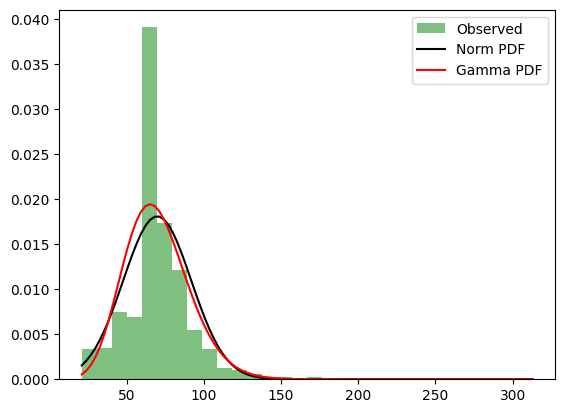

Хи-квадрат для нормального распределения: 47456240162798870528.00
Хи-квадрат для гамма распределения: 1890391655.06
Критическое значение Хи-квадрат: 15.51


In [27]:
# Выбираем данные LotFrontage
lot_frontage = df['LotFrontage'].dropna()

# Подбор параметров распределений
params_norm = stats.norm.fit(lot_frontage)
params_gamma = stats.gamma.fit(lot_frontage)

# Гистограмма
plt.hist(lot_frontage, bins=30, density=True, alpha=0.5, color='g', label='Observed')

# Ожидаемые частоты для нормального распределения
x = np.linspace(lot_frontage.min(), lot_frontage.max(), 100)
pdf_norm = stats.norm.pdf(x, *params_norm)
plt.plot(x, pdf_norm, 'k-', label='Norm PDF')

# Ожидаемые частоты для гамма распределения
pdf_gamma = stats.gamma.pdf(x, *params_gamma)
plt.plot(x, pdf_gamma, 'r-', label='Gamma PDF')

plt.legend()
plt.show()

# Хи-квадрат тест
def chi_square_test(observed_freq, expected_freq):
    chi2_stat = np.sum((observed_freq - expected_freq) ** 2 / expected_freq)
    return chi2_stat

# Ожидаемые частоты
observed_freq, bin_edges = np.histogram(lot_frontage, bins=10)
expected_freq_norm = stats.norm.pdf(bin_edges[:-1], *params_norm) * len(lot_frontage)
expected_freq_gamma = stats.gamma.pdf(bin_edges[:-1], *params_gamma) * len(lot_frontage)

# Вычисление Хи-квадрат статистики
chi2_norm = chi_square_test(observed_freq, expected_freq_norm)
chi2_gamma = chi_square_test(observed_freq, expected_freq_gamma)

# Степени свободы
dof = len(bin_edges) - 1 - 2  # для нормального распределения

# Критическое значение
critical_value = stats.chi2.ppf(0.95, dof)

print(f'Хи-квадрат для нормального распределения: {chi2_norm:.2f}')
print(f'Хи-квадрат для гамма распределения: {chi2_gamma:.2f}')
print(f'Критическое значение Хи-квадрат: {critical_value:.2f}')
